# Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

In [2]:
ts_df = pd.read_csv("cleaned_data/model_data_clean.csv", index_col=0)

In [3]:
ts_df.head()

,id,host_id,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,minimum_nights,...,neighborhood_Whites_Creek,property_type_Condominium,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,inventory,avg_home_value
2015-06-01,4.911123e+06,1.847859e+07,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,1.545455,...,3.0,1.0,78.0,11.0,1.0,0.0,39.0,3.0,121,198388.0
2015-07-01,4.585624e+06,1.588542e+07,37202.203096,36.157222,-86.767316,4.607430,1.507740,2.308978,202.349226,1.698452,...,9.0,33.0,1048.0,100.0,18.0,0.0,451.0,18.0,1615,199865.0
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,201227.0
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,202952.0
2015-10-01,5.435875e+06,1.857827e+07,37201.418483,36.156564,-86.767390,4.795735,1.534597,2.406161,200.524171,1.747867,...,23.0,54.0,1360.0,130.0,51.0,0.0,566.0,30.0,2110,204617.0


# Set Time Series Index

In [4]:
ts_df.reset_index(inplace=True)
ts_df['index'] = pd.to_datetime(ts_df['index'],format='%Y/%m/%d')
ts_df.set_index('index', inplace=True)
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   zipcode                           39 non-null     float64
 3   latitude                          39 non-null     float64
 4   longitude                         39 non-null     float64
 5   accommodates                      39 non-null     float64
 6   bathrooms                         39 non-null     float64
 7   beds                              39 non-null     float64
 8   price                             39 non-null     float64
 9   minimum_nights                    39 non-null     float64
 10  maximum_nights                    39 non-null     float64
 11  availability_30                   39 non-null     flo

# Deal with Missing Time Series Values

## Visualize the trend

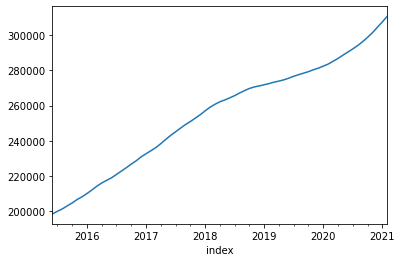

In [5]:
ts_df.avg_home_value.plot();

Appears to be trend without seasonality

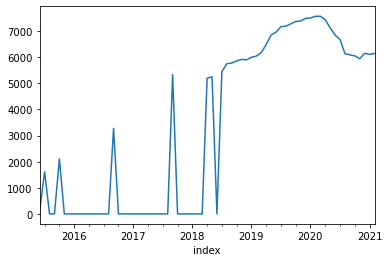

In [6]:
ts_df.inventory.plot();

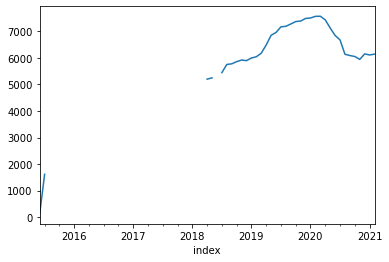

In [7]:
ts_df['inventory'] = ts_df['inventory'].replace(0,np.nan)
ts_df.inventory.plot();

Data appears to be missing throughout 2016 and 2017. Let's see what looking at just 2018 onward looks like.

## Focus on Dates after 2018

In [8]:
post_18_ts_df = ts_df['2018':]

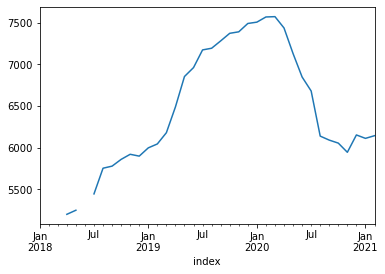

In [9]:
post_18_ts_df.inventory.plot();

There are still a handful of missing values. Let's use linear interpolation to fill in these values.

In [10]:
post_18_ts_df = post_18_ts_df.interpolate()

In [11]:
post_18_ts_df.dropna(inplace=True)

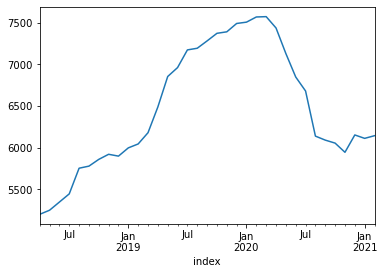

In [12]:
post_18_ts_df.inventory.plot();

## Interpolate Full Dataset

In [13]:
ts_df.interpolate(inplace=True)

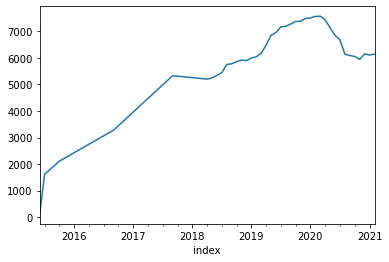

In [14]:
ts_df.inventory.plot();

# Explore Time Series

## Decompose Time Series

In [15]:
result = seasonal_decompose(ts_df['avg_home_value'], model='add')

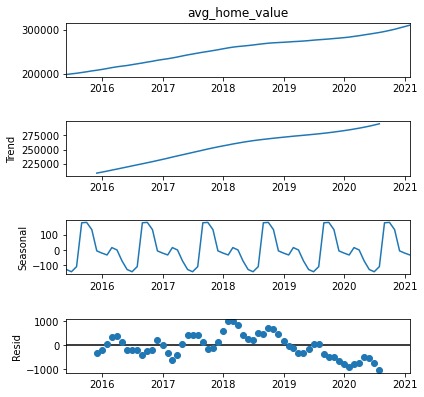

In [16]:
fig = result.plot()
fig.set_figheight(6)

In [17]:
decomposition = seasonal_decompose(ts_df['avg_home_value'])

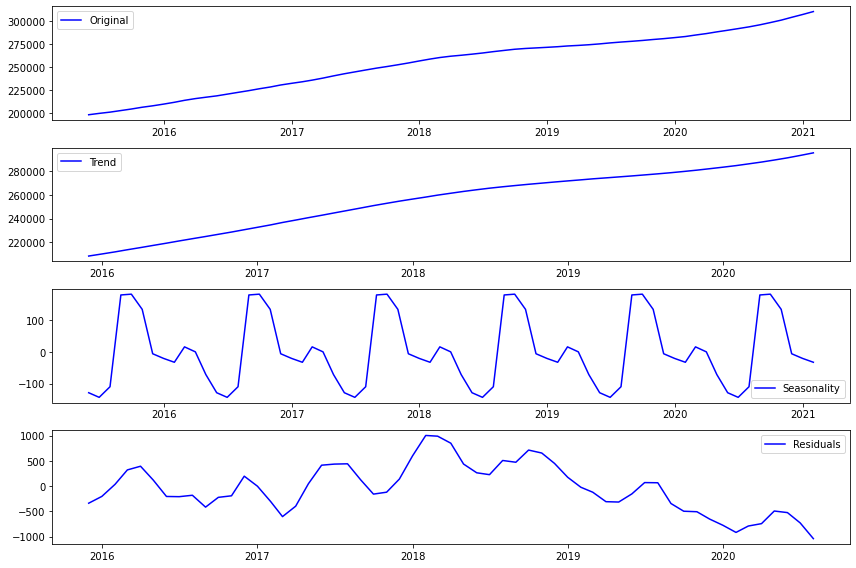

In [18]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts_df['avg_home_value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

## Check Time Series stationarity

In [19]:
def stationarity_check(ts):
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    fig = plt.figure(figsize=(8,5))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput

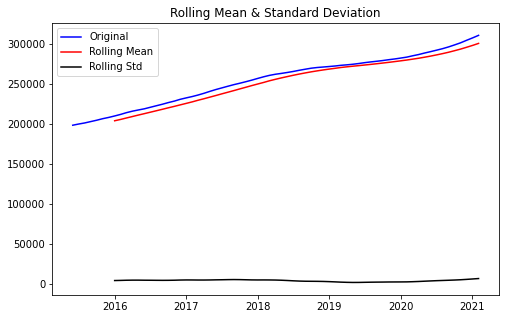

Test Statistic                  0.624229
p-value                         0.988198
#Lags Used                     10.000000
Number of Observations Used    58.000000
dtype: float64

In [20]:
ts = ts_df['avg_home_value']
stationarity_check(ts)

Because the p-value is much greater than 0.05, we cannot reject the null hypothesis that the data is not stationary.

## Look at ACF and PACF plots

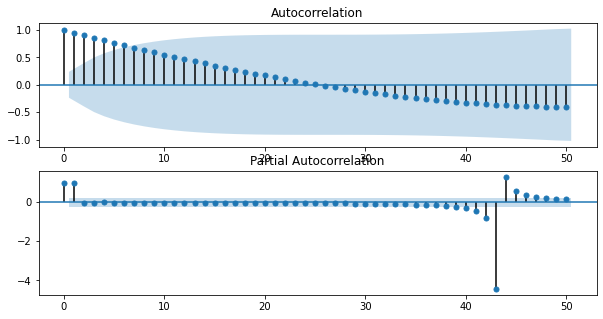

In [21]:
# fig,ax= plt.subplots(2,1, figsize=(10,5))
# fig=sm.tsa.graphics.plot_acf(ts, lags=50, ax=ax[0])
# fig=sm.tsa.graphics.plot_pacf(ts, lags=50, ax=ax[1])
# plt.show()

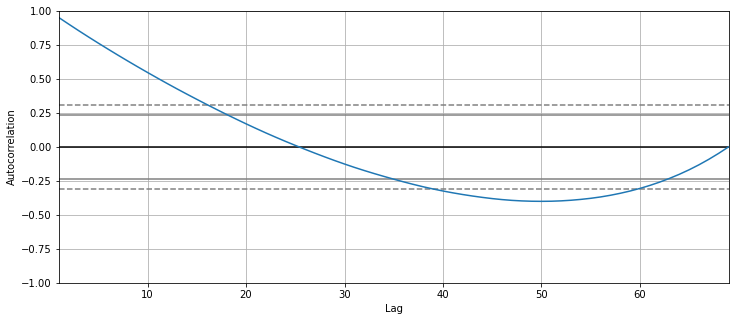

In [22]:
# plt.figure(figsize=(12,5))
# pd.plotting.autocorrelation_plot(ts);

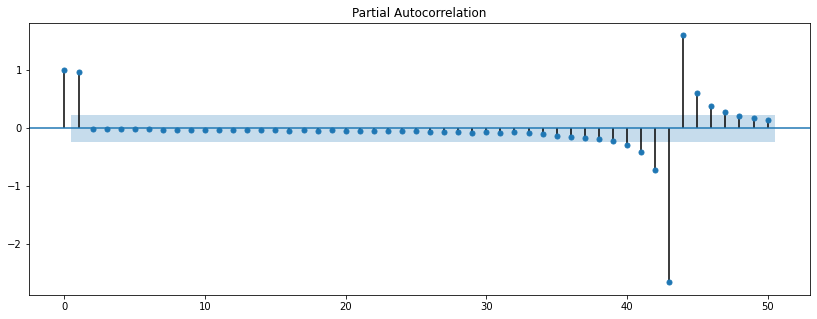

In [21]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(ts, lags=50);

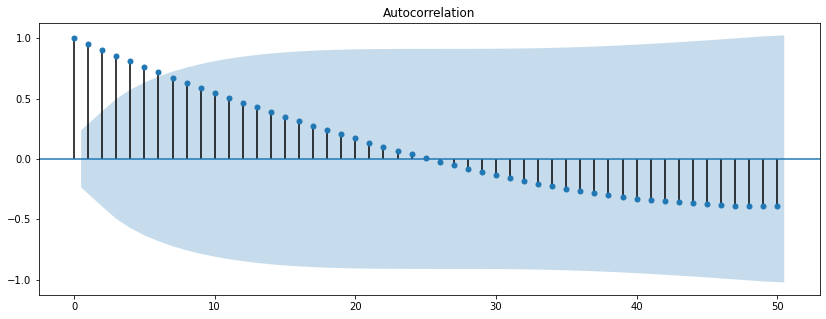

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(ts, lags=50);

# ARMA Time Series Model

* Come back to*

## Differencing

In [23]:
ts_diff = ts.diff(periods=1)
ts_diff.dropna(inplace=True)

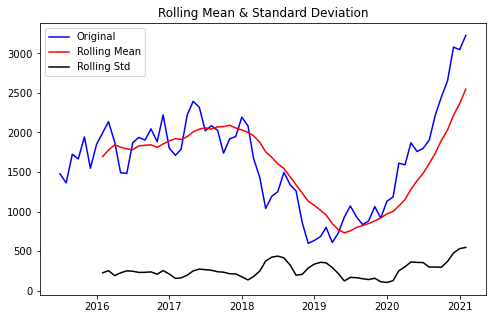

Test Statistic                 -3.483200
p-value                         0.008429
#Lags Used                     11.000000
Number of Observations Used    56.000000
dtype: float64

In [24]:
stationarity_check(ts_diff)

We can now reject the null hypothesis and confirm the data is stationary.

# SARIMA Time Series Model

## Set up Data for Modeling

In [25]:
home_values = ts_df['avg_home_value']

In [26]:
# X = home_values.values

In [27]:
train_size = int(len(home_values)*.7)
test_size = int(len(home_values)-train_size)
train, test = home_values[0:train_size], home_values[train_size:len(home_values)]
print('Observations: %d' % (len(home_values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 69
Training Observations: 48
Testing Observations: 21


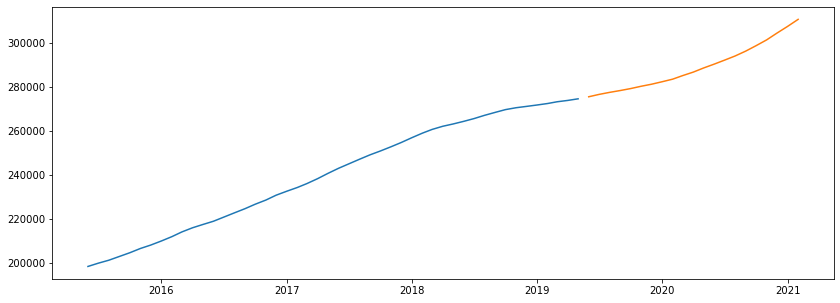

In [28]:
plt.plot(train)
plt.plot(test)
plt.show()

## Parameter Selection for the SARIMA Model

In [29]:
# set seasonal s equal to 12
s=12
# allow p, d and q to take any value from 0 to 1
p = d = q = range(0,2)

# generate all combinations of p,d and q
pdq = list(itertools.product(p, d, q))

# generate all combinations including seasonal combinations
pdqs = [(x[0], x[1], x[2], s) for x in pdq]

In [30]:
# run grid with parameters above and select best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(train,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 1300.8230609538462
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 1130.706083548577
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 798.9331500871451
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 524.02157038227
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 721.7873083191544
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1039.0935159228868
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 483.98081615284605
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 437.52610372804617
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 41881.01203245639
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = nan
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 758.615438262401
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 499.13524409318745
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 965.6123735074972
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = nan
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 529.8899324443589
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 495.3898344439714
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 816.8576537210402
ARIMA (0, 1, 0) x (0, 0

In [31]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           300.812
Name: 63, dtype: object

In [32]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

## Fit SARIMA Model

In [33]:
SARIMA_MODEL = SARIMAX(train,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [34]:
output = SARIMA_MODEL.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -145.406
Date:                            Sun, 04 Apr 2021   AIC                            300.812
Time:                                    16:44:02   BIC                            306.034
Sample:                                06-01-2015   HQIC                           301.945
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9821      0.093     10.534      0.000       0.799       1.165
ma.L1          0.1519      0.216      0.705      0.481      -0.271       0.575
ar.S.L12      -0.6322      0.138     -4.582      0.000      -0.903      -0.362
ma.S.L12      -0.0055      0.054     -0.102      0.919      -0.112       0.101
sigma2      6.045e+04   3.08e+04      1.965      0.049     145.992    1.21e+05
===================================================================================
Ljung-Box (Q):                       28.00   Jarque-Bera (JB):                 1.68
Prob(Q):                              0.11   Prob(JB):                         0.43
Heteroskedasticity (H):               1.49   Skew:                            -0.35
Prob(H) (two-sided):                  0.61   Kurtosis:                         1.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
coef = output.params
coef

ar.L1           0.982083
ma.L1           0.151929
ar.S.L12       -0.632222
ma.S.L12       -0.005546
sigma2      60448.206094
dtype: float64

## Run Model Diagnostics

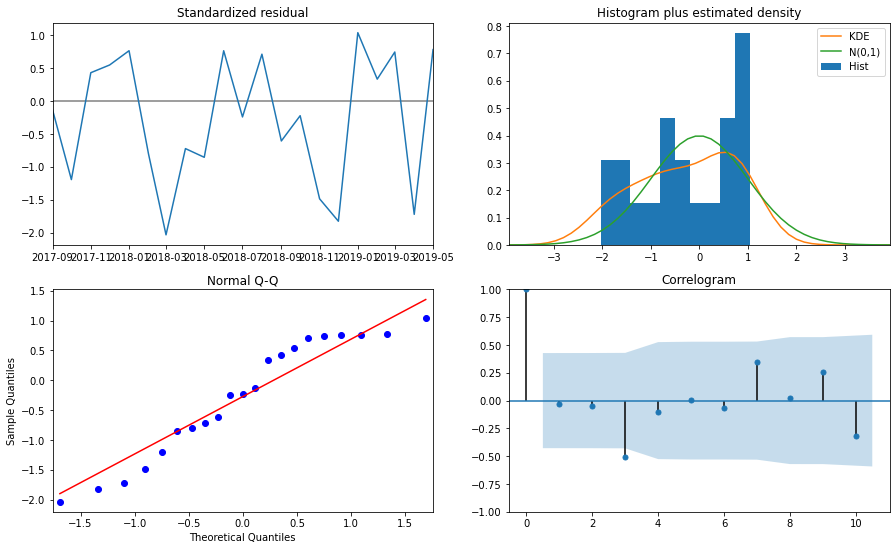

In [36]:
output.plot_diagnostics(figsize=(15,9));

It appears the residuals are normally distributed based on the KDE plot and the qq-plot, although there could be some violations at either tail.
The residuals appear to have white noise and not showing signs of seasonality. The residuals are also not highly correlated with themselves based on the autocorrelation plot.

## Make Predictions for Test Set

Get rid of this section??*

In [37]:
# history = [train[i] for i in range(len(train))]

In [38]:
# def predict(coef, history):
#     yhat = coef[0]
#     for i in range(1, len(coef)):
#         yhat += coef[i]*history[-i]
#     return yhat

In [39]:
# from statsmodels.tsa.ar_model import AutoReg
# from sklearn.metrics import mean_squared_error
# predictions = []
# for t in range(len(test)):
#     yhat = predict(coef,history)
#     obs = test[t]
#     predictions.append(yhat)
#     history.append(obs)
# rmse = np.sqrt(mean_squared_error(test,predictions))
# print('Test RMSE: %.3f' % rmse)

Test RMSE: 17111031246.874


## One-Step Ahead Forecasting

In [40]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_conf = pred.conf_int()

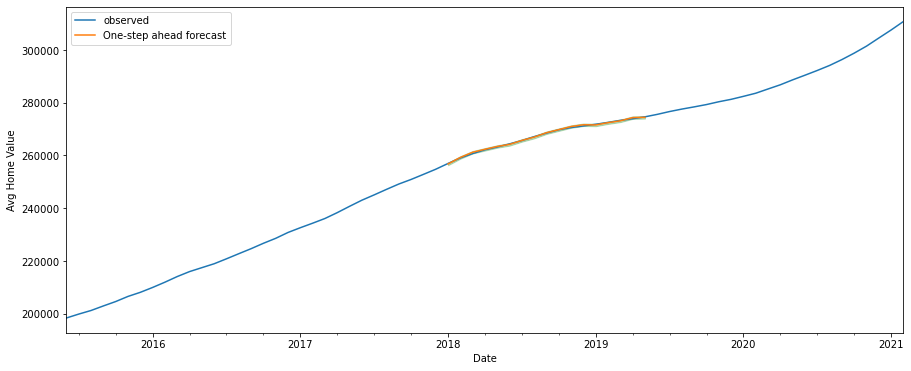

In [41]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [42]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

260.4889637061514


## Dynamic Forecast

In [43]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

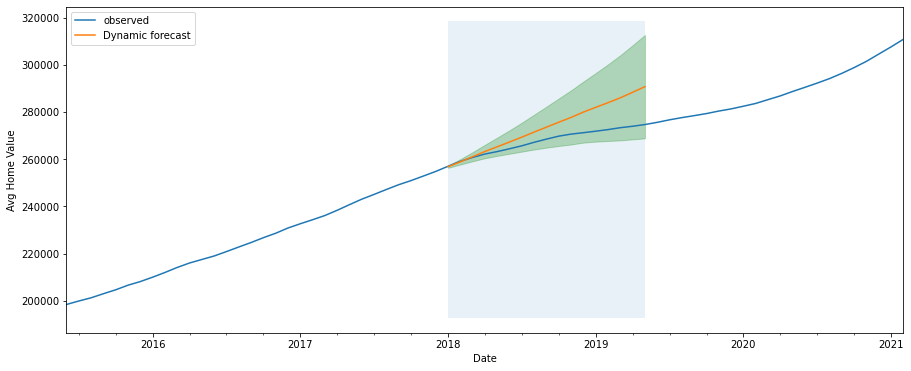

In [44]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g',alpha=0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [45]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

8012.730651010307


Much higher RMSE using a dynamic model.

## Predicting Future Values

In [48]:
prediction = output.get_forecast(steps=48)
pred_conf = prediction.conf_int()

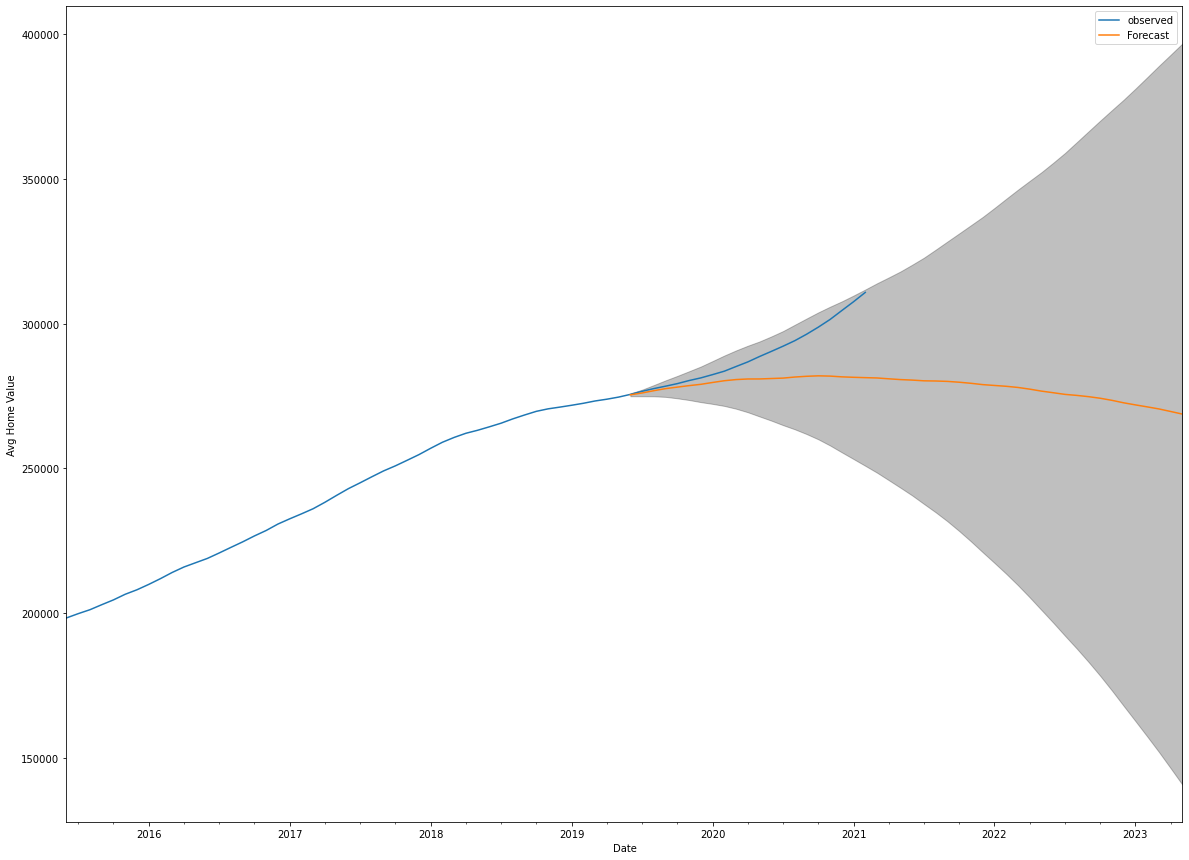

In [49]:
ax = home_values.plot(label='observed', figsize=(20,15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

# SARIMAX Time Series Model

## Parameter Selection for SARIMAX Model

For our exogenous parameters in our SARIMAX model, we will use the most important features selected from our regression model.

In [50]:
final_reg_df = pd.read_csv("cleaned_data/final_reg_features.csv", index_col=0)

In [51]:
features = list(final_reg_df.columns)

In [52]:
final_time_series_df = ts_df[features]
post_18_final_time_series_df = post_18_ts_df[features]

In [53]:
final_time_series_df

,avg_home_value,beds,number_of_reviews,host_is_superhost,neighborhood_North_Nashville
index,,,,,
2015-06-01,198388.0,2.033058,17.206612,23,6.0
2015-07-01,199865.0,2.308978,16.536223,286,49.0
2015-08-01,201227.0,2.341373,16.929362,0,0.0
2015-09-01,202952.0,2.373767,17.322501,0,0.0
2015-10-01,204617.0,2.406161,17.715640,434,76.0
...,...,...,...,...,...
2020-10-01,298809.0,3.715442,53.884558,3533,673.0
2020-11-01,301461.0,3.692683,54.217325,3429,689.0
2020-12-01,304539.0,3.645701,53.611572,3495,680.0


In [54]:
home_values = final_time_series_df['avg_home_value']
exog = final_time_series_df.drop('avg_home_value', axis=1)

In [55]:
train_size = int(len(home_values)*.7)
train, test = home_values[0:train_size], home_values[train_size:len(X)]
train_exog, test_exog = exog[0:train_size], exog[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 69
Training Observations: 48
Testing Observations: 21


In [56]:
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(train, train_exog,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))         

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 868.5652197532814
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 1382.3985930362328
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 660.5888940139937
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 443.95854698660617
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 674.6976385963668
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1479.6347273670347
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 457.5719974730623
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 437.4974321685482
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 832.4989908530738
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = 2852.3172460268815
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 641.1889231450348
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 414.59834101148
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 662.1838356744257
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = 5358.110458971895
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 454.32499232707835
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 413.7058044553173
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 766.20519433

In [57]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           305.404
Name: 59, dtype: object

In [58]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

## Fit SARIMAX Model

In [59]:
SARIMA_MODEL = SARIMAX(train, train_exog,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [60]:
output = SARIMA_MODEL.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -144.702
Date:                            Sun, 04 Apr 2021   AIC                            305.404
Time:                                    16:47:37   BIC                            313.760
Sample:                                06-01-2015   HQIC                           307.218
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
beds                           473.0373   1037.150      0.456      0.648   -1559.740    2505.815
number_of_reviews              -42.7573     61.692     -0.693      0.488    -163.670      78.156
host_is_superhost               -0.1333      0.327     -0.407      0.684      -0.775       0.508
neighborhood_North_Nashville     0.9491      1.581      0.600      0.548      -2.150       4.049
ar.L1                            1.0057      0.100     10.025      0.000       0.809       1.202
ma.L1                            0.5200      0.221      2.349      0.019       0.086       0.954
ma.S.L12                        -0.6161      0.233     -2.642      0.008      -1.073      -0.159
sigma2                        3.768e+04   1.99e+04      1.891      0.059   -1383.798    7.67e+04
===================================================================================
Ljung-Box (Q):                       30.94   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.06   Prob(JB):                         0.53
Heteroskedasticity (H):               0.78   Skew:                            -0.26
Prob(H) (two-sided):                  0.75   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

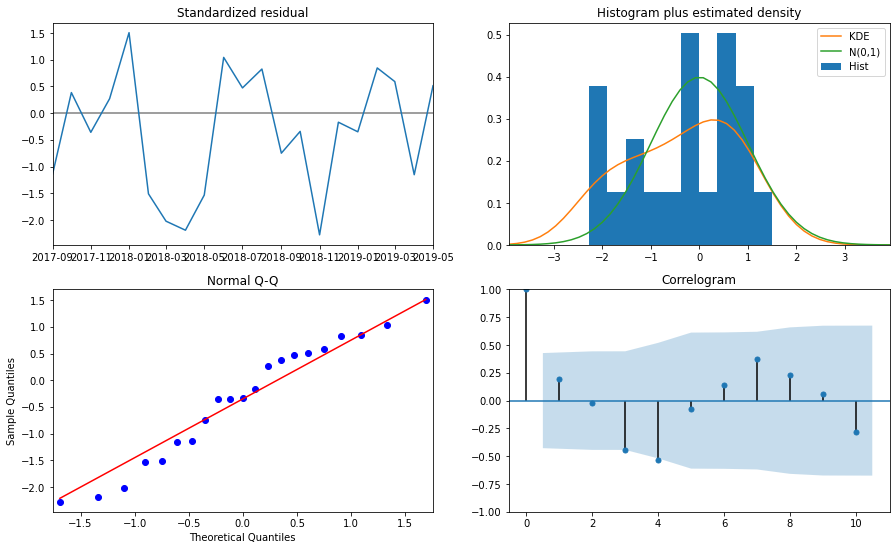

In [61]:
output.plot_diagnostics(figsize=(15,9));

## Make Predictions

In [62]:
# history = [train[i] for i in range(len(train))]

# predictions = []
# for t in range(len(test)):
#     yhat = predict(coef,history)
#     obs = test[t]
#     predictions.append(yhat)
#     history.append(obs)
# rmes = np.sqrt(mean_squared_error(test,predictions))
# print('Test RMSE: %.3f' % rmse)

Test RMSE: 8012.731


In [63]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_conf = pred.conf_int()

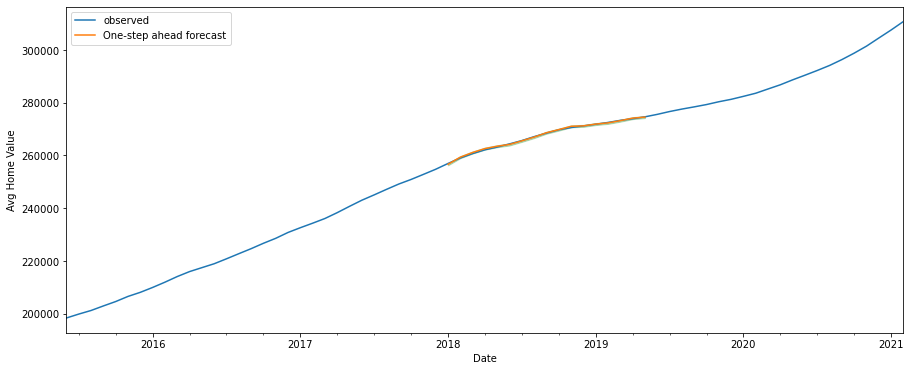

In [64]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [65]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

251.48092797841667


## Dynamic Forecast

In [69]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

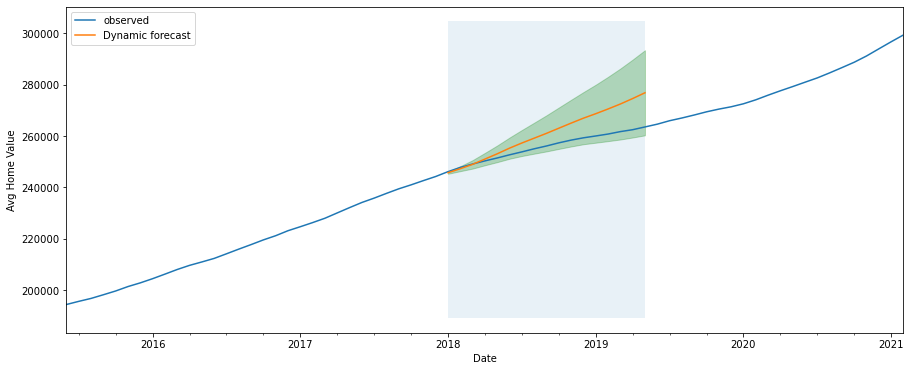

In [70]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g',alpha=0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [66]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

8012.730651010307


Much higher RMSE using a dynamic model.

## Predicting Future Values

# Alternate Method: Use Auto Arima

## Parameter Selection Using Auto Arima

In [71]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train, 
 exogenous= train_exog,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=741.687, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=734.036, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=741.073, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=719.438, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=746.179, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=742.543, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=743.612, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=745.915, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.939 seconds


In [72]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -352.719
Date:                Fri, 02 Apr 2021   AIC                            719.438
Time:                        15:26:20   BIC                            732.389
Sample:                    06-01-2015   HQIC                           724.311
                         - 05-01-2019                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept                      635.8559    201.878      3.150      0.002     240.183    1031.529
bathrooms                     7.391e+04   1.89e+04      3.905      0.000    3.68e+04    1.11e+05
number_of_reviews              531.0072    183.292      2.897      0.004     171.761     890.253
host_is_superhost               -1.5843      1.196     -1.324      0.185      -3.929       0.761
neighborhood_North_Nashville     7.5101      5.878      1.278      0.201      -4.010      19.030
ma.L1                           -0.1578      0.100     -1.576      0.115      -0.354       0.038
sigma2                        2.191e+05   8.45e+04      2.593      0.010    5.35e+04    3.85e+05
===================================================================================
Ljung-Box (Q):                      164.02   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.00   Prob(JB):                         0.28
Heteroskedasticity (H):               1.02   Skew:                            -0.48
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Train the Model

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train, 
               exog=train_exog,
               order=(0,1,1),
               enforce_invertibility=False, enforce_stationarity=False)

In [74]:
results = model.fit()

In [75]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         avg_home_value   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -336.271
Date:                Fri, 02 Apr 2021   AIC                            684.542
Time:                        15:26:31   BIC                            695.382
Sample:                    06-01-2015   HQIC                           688.583
                         - 05-01-2019                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathrooms                     7.392e+04   1.46e+04      5.069      0.000    4.53e+04    1.02e+05
number_of_reviews             1016.1107    115.306      8.812      0.000     790.116    1242.106
host_is_superhost               -1.7271      0.677     -2.551      0.011      -3.054      -0.400
neighborhood_North_Nashville     7.6540      3.409      2.245      0.025       0.973      14.335
ma.L1                            0.8024      0.147      5.455      0.000       0.514       1.091
sigma2                        1.909e+05   5.82e+04      3.281      0.001    7.69e+04    3.05e+05
===================================================================================
Ljung-Box (Q):                       31.53   Jarque-Bera (JB):                15.26
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -1.03
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make Predictions

In [76]:
steps = 0
predictions= results.predict(start = train_size, end=train_size+test_size+(steps)-1,exog=test_exog)

In [77]:
forecast_1= results.forecast(steps=test_size, exog=test_exog)

In [78]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_exog.index
predictions['Actual'] = test
predictions.rename(columns={0:'Pred'}, inplace=True)

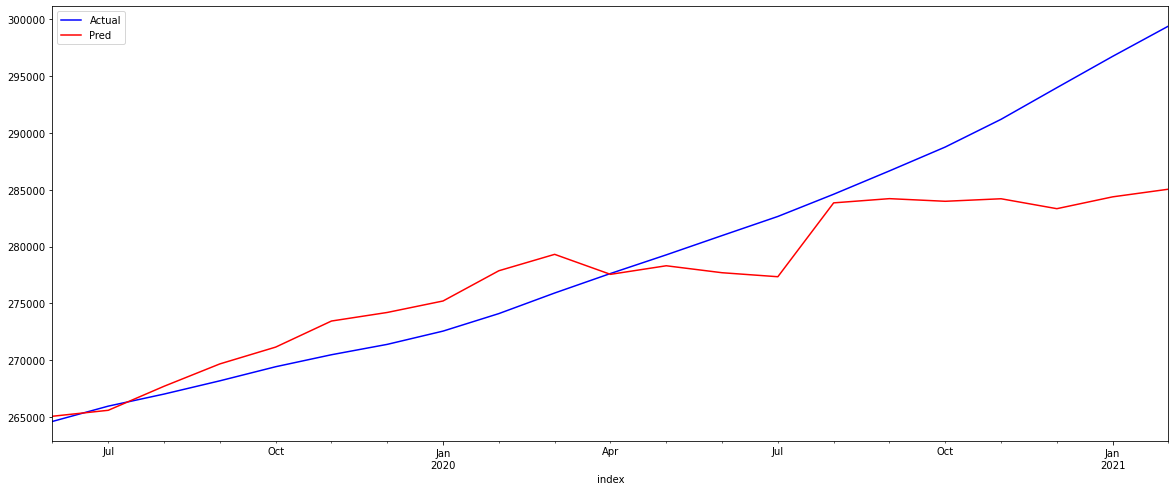

In [79]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [80]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

5539.658880053002